In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

features_dir = Path(r"C:\Users\Atif\Documents\easy_features")
X = np.load(features_dir / "X.npy")
meta = pd.read_csv(features_dir / "meta.csv")

print("X shape:", X.shape)
print(meta["language"].value_counts())
meta.head()


X shape: (10000, 80)
language
english    5000
bangla     5000
Name: count, dtype: int64
X shape: (10000, 80)
language
english    5000
bangla     5000
Name: count, dtype: int64


,path,language
0,C:\Users\Atif\Documents\easy_processed\english...,english
1,C:\Users\Atif\Documents\easy_processed\english...,english
2,C:\Users\Atif\Documents\easy_processed\english...,english
3,C:\Users\Atif\Documents\easy_processed\english...,english
4,C:\Users\Atif\Documents\easy_processed\english...,english


,path,language
0,C:\Users\Atif\Documents\easy_processed\english...,english
1,C:\Users\Atif\Documents\easy_processed\english...,english
2,C:\Users\Atif\Documents\easy_processed\english...,english
3,C:\Users\Atif\Documents\easy_processed\english...,english
4,C:\Users\Atif\Documents\easy_processed\english...,english


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42, stratify=meta["language"])
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (8000, 80) Val: (2000, 80)
Train: (8000, 80) Val: (2000, 80)


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class VAE(nn.Module):
    def __init__(self, input_dim=80, latent_dim=16, hidden1=256, hidden2=128):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden2, latent_dim)
        self.logvar = nn.Linear(hidden2, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        recon = self.dec(z)
        return recon, mu, logvar

def vae_loss(x, recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss, kl


Device: cpu
Device: cpu


In [6]:
import copy

BATCH = 64
EPOCHS = 50
LR = 1e-3
LATENT_DIM = 16

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=BATCH, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val)), batch_size=BATCH, shuffle=False)

vae = VAE(input_dim=X.shape[1], latent_dim=LATENT_DIM).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    vae.train()
    tr_loss = tr_rec = tr_kl = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        recon, mu, logvar = vae(xb)
        loss, rec, kl = vae_loss(xb, recon, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_loss += loss.item()
        tr_rec += rec.item()
        tr_kl += kl.item()

    vae.eval()
    va_loss = va_rec = va_kl = 0.0
    with torch.no_grad():
        for (xb,) in val_loader:
            xb = xb.to(device)
            recon, mu, logvar = vae(xb)
            loss, rec, kl = vae_loss(xb, recon, mu, logvar)
            va_loss += loss.item()
            va_rec += rec.item()
            va_kl += kl.item()

    tr_loss /= len(train_loader)
    tr_rec  /= len(train_loader)
    tr_kl   /= len(train_loader)
    va_loss /= len(val_loader)
    va_rec  /= len(val_loader)
    va_kl   /= len(val_loader)

    if va_loss < best_val:
        best_val = va_loss
        best_state = copy.deepcopy(vae.state_dict())

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train {tr_loss:.4f} (rec {tr_rec:.4f} kl {tr_kl:.4f}) "
              f"| val {va_loss:.4f} (rec {va_rec:.4f} kl {va_kl:.4f})")

# Save best
out_dir = Path(r"C:\Users\Atif\Documents\results_easy")
out_dir.mkdir(parents=True, exist_ok=True)
torch.save(best_state, out_dir / "vae_best.pt")
print("Saved:", out_dir / "vae_best.pt")


Epoch 01 | train 0.9497 (rec 0.9130 kl 0.0367) | val 0.8894 (rec 0.8372 kl 0.0523)
Epoch 01 | train 0.9497 (rec 0.9130 kl 0.0367) | val 0.8894 (rec 0.8372 kl 0.0523)
Epoch 05 | train 0.8701 (rec 0.7774 kl 0.0927) | val 0.8607 (rec 0.7661 kl 0.0946)
Epoch 05 | train 0.8701 (rec 0.7774 kl 0.0927) | val 0.8607 (rec 0.7661 kl 0.0946)
Epoch 10 | train 0.8496 (rec 0.7293 kl 0.1203) | val 0.8424 (rec 0.7295 kl 0.1130)
Epoch 10 | train 0.8496 (rec 0.7293 kl 0.1203) | val 0.8424 (rec 0.7295 kl 0.1130)
Epoch 15 | train 0.8354 (rec 0.7006 kl 0.1348) | val 0.8313 (rec 0.6917 kl 0.1396)
Epoch 15 | train 0.8354 (rec 0.7006 kl 0.1348) | val 0.8313 (rec 0.6917 kl 0.1396)
Epoch 20 | train 0.8300 (rec 0.6878 kl 0.1422) | val 0.8270 (rec 0.6887 kl 0.1383)
Epoch 20 | train 0.8300 (rec 0.6878 kl 0.1422) | val 0.8270 (rec 0.6887 kl 0.1383)
Epoch 25 | train 0.8270 (rec 0.6787 kl 0.1483) | val 0.8282 (rec 0.6901 kl 0.1381)
Epoch 25 | train 0.8270 (rec 0.6787 kl 0.1483) | val 0.8282 (rec 0.6901 kl 0.1381)
Epoc

In [7]:
vae.load_state_dict(torch.load(out_dir / "vae_best.pt", map_location=device))
vae.eval()

X_tensor = torch.from_numpy(X_scaled).to(device)

with torch.no_grad():
    h = vae.enc(X_tensor)
    Z = vae.mu(h).cpu().numpy()   # use mu as embedding (stable)

np.save(out_dir / "Z.npy", Z)
print("Z shape:", Z.shape)
print("Saved:", out_dir / "Z.npy")


Z shape: (10000, 16)
Saved: C:\Users\Atif\Documents\results_easy\Z.npy
Z shape: (10000, 16)
Saved: C:\Users\Atif\Documents\results_easy\Z.npy


In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd

k = 2

# VAE latent -> KMeans
kmeans_vae = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_vae = kmeans_vae.fit_predict(Z)

sil_vae = silhouette_score(Z, labels_vae)
ch_vae = calinski_harabasz_score(Z, labels_vae)

# PCA -> KMeans baseline
pca = PCA(n_components=16, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_pca = kmeans_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)

metrics = pd.DataFrame([
    {"method": "VAE_latent+KMeans", "k": k, "silhouette": sil_vae, "calinski_harabasz": ch_vae},
    {"method": "PCA(16)+KMeans",    "k": k, "silhouette": sil_pca, "calinski_harabasz": ch_pca},
])

metrics.to_csv(out_dir / "metrics.csv", index=False)
np.save(out_dir / "kmeans_labels_vae.npy", labels_vae)
np.save(out_dir / "kmeans_labels_pca.npy", labels_pca)

print(metrics)
print("Saved:", out_dir / "metrics.csv")


              method  k  silhouette  calinski_harabasz
0  VAE_latent+KMeans  2    0.236712        2927.374512
1     PCA(16)+KMeans  2    0.183314        2402.925781
Saved: C:\Users\Atif\Documents\results_easy\metrics.csv
              method  k  silhouette  calinski_harabasz
0  VAE_latent+KMeans  2    0.236712        2927.374512
1     PCA(16)+KMeans  2    0.183314        2402.925781
Saved: C:\Users\Atif\Documents\results_easy\metrics.csv


Matplotlib is building the font cache; this may take a moment.
Matplotlib is building the font cache; this may take a moment.


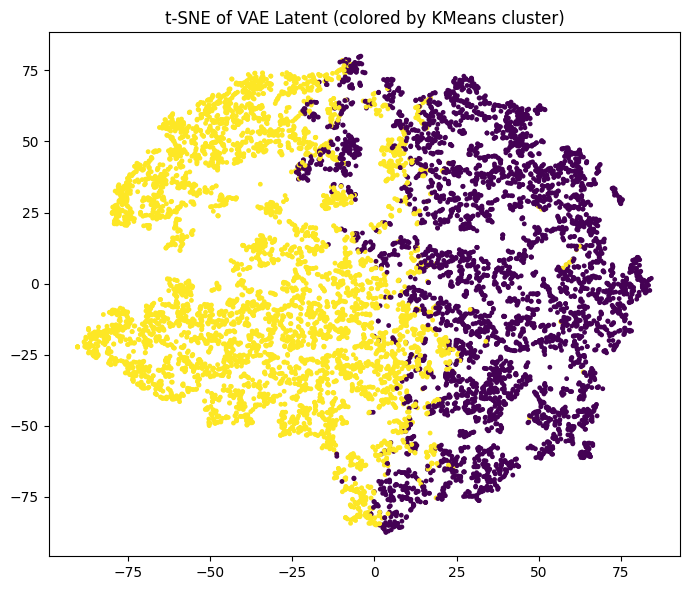

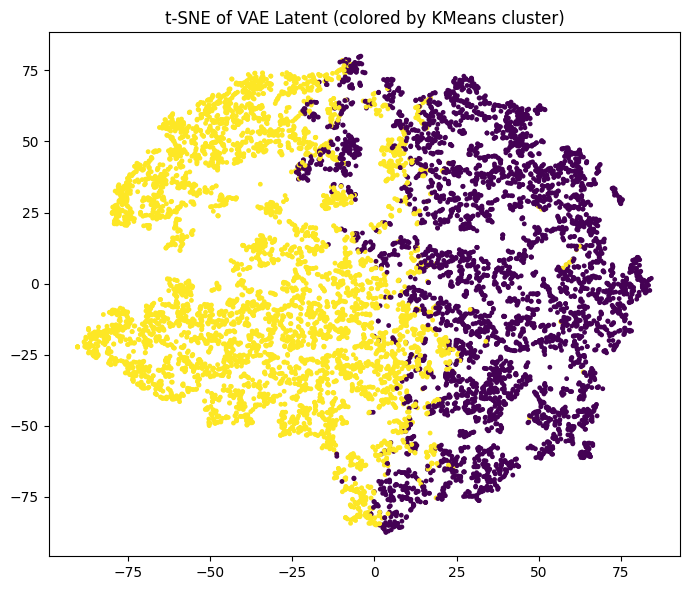

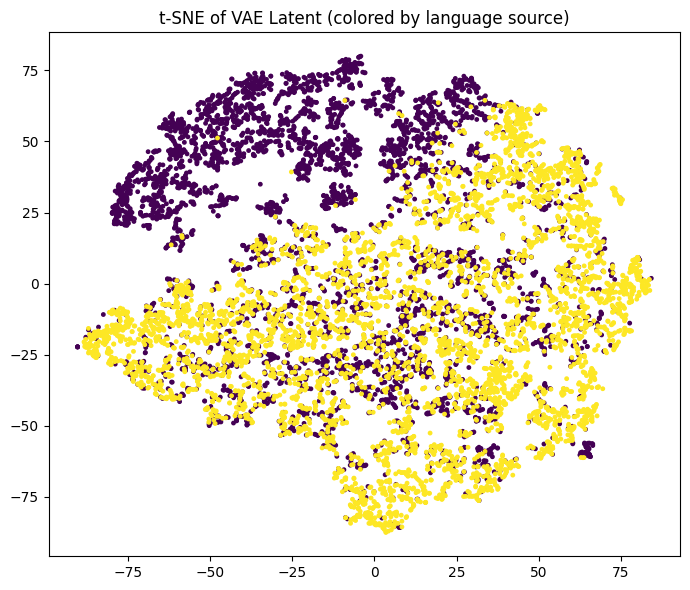

Saved plots to: C:\Users\Atif\Documents\results_easy


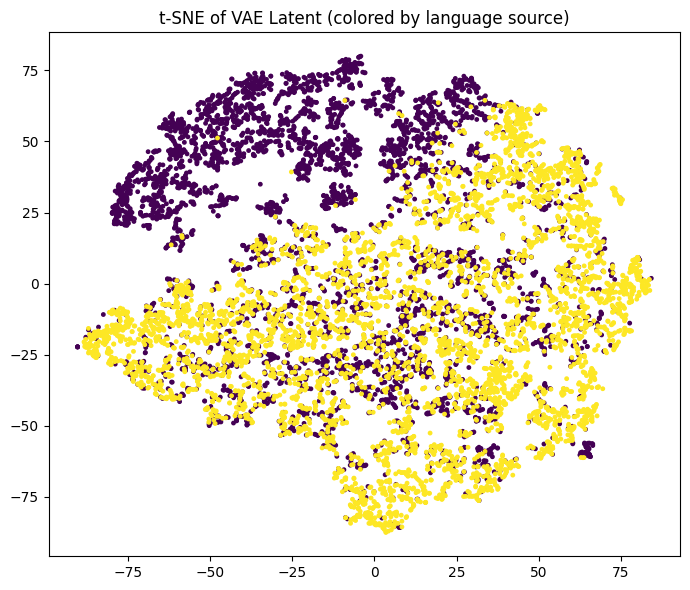

Saved plots to: C:\Users\Atif\Documents\results_easy


In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca")
Z_2d = tsne.fit_transform(Z)

langs = meta["language"].values

plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], s=6, c=labels_vae)
plt.title("t-SNE of VAE Latent (colored by KMeans cluster)")
plt.tight_layout()
plt.savefig(out_dir / "tsne_cluster.png", dpi=200)
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(Z_2d[:,0], Z_2d[:,1], s=6, c=(langs == "bangla").astype(int))
plt.title("t-SNE of VAE Latent (colored by language source)")
plt.tight_layout()
plt.savefig(out_dir / "tsne_language.png", dpi=200)
plt.show()

print("Saved plots to:", out_dir)


In [12]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Convert language to 0/1
y = (meta["language"].values == "bangla").astype(int)

# ARI / NMI (label agreement, 1.0 = perfect)
ari = adjusted_rand_score(y, labels_vae)
nmi = normalized_mutual_info_score(y, labels_vae)

# Purity
purity = 0
for c in np.unique(labels_vae):
    idx = np.where(labels_vae == c)[0]
    if len(idx) == 0: 
        continue
    purity += np.max(np.bincount(y[idx]))
purity /= len(y)

print("ARI:", ari)
print("NMI:", nmi)
print("Purity:", purity)


ARI: 0.03630866592703135
NMI: 0.02657732072765034
Purity: 0.5954
ARI: 0.03630866592703135
NMI: 0.02657732072765034
Purity: 0.5954


In [26]:
import pandas as pd
print(pd.crosstab(meta["language"], labels_vae, normalize="index"))



col_0          0       1
language                
bangla    0.5630  0.4370
english   0.3722  0.6278
col_0          0       1
language                
bangla    0.5630  0.4370
english   0.3722  0.6278


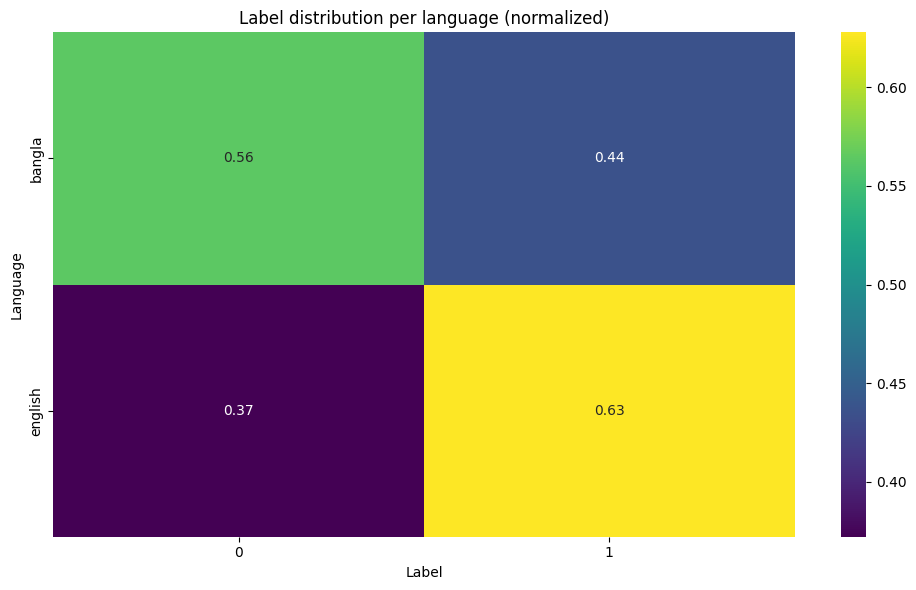

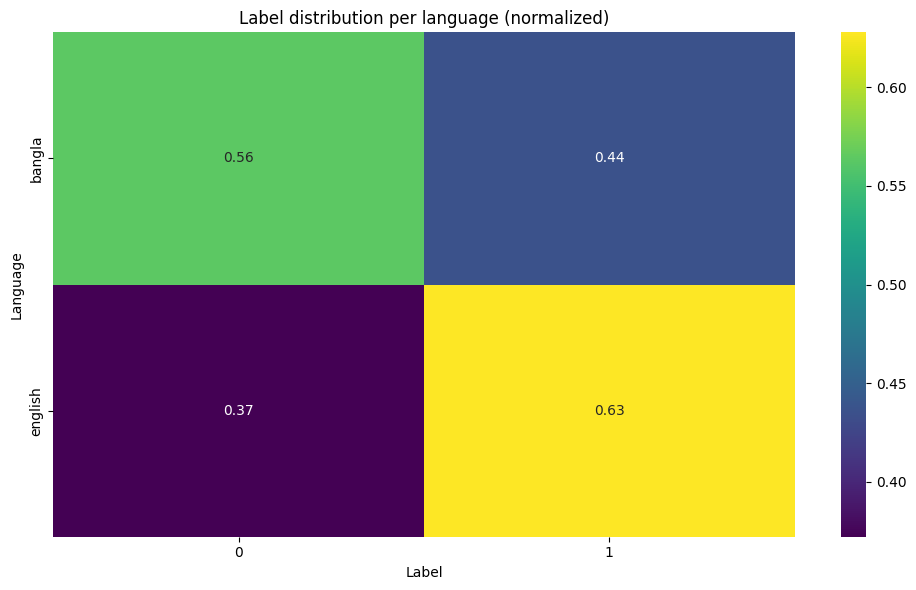

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ct = pd.crosstab(meta["language"], labels_vae, normalize="index")

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt=".2f", cmap="viridis", ax=ax)
ax.set_title("Label distribution per language (normalized)")
ax.set_xlabel("Label")
ax.set_ylabel("Language")
fig.tight_layout()

plt.show()
plt.close(fig)   # prevents a second auto-render in some environments

